In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import argparse
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import time
import gc  # For garbage collection
import json


In [ ]:


# Set environment variables for faster training
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Reduce TensorFlow logging
os.environ["TF_NUM_INTEROP_THREADS"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "8"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=2"  # Enable XLA JIT compilation

# Configure TensorFlow for maximum performance
def configure_performance():
    """Configure TensorFlow for maximum training performance"""
    print("Configuring TensorFlow for maximum performance...")

    # Get TensorFlow version
    tf_version = tf.__version__
    print(f"TensorFlow version: {tf_version}")

    # Set thread optimization
    tf.config.threading.set_inter_op_parallelism_threads(2)
    tf.config.threading.set_intra_op_parallelism_threads(8)

    # Configure GPU options for optimal performance
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Memory growth should be set before GPUs have been initialized
            for gpu in gpus:
                # Don't allow TensorFlow to allocate all memory at once
                tf.config.experimental.set_memory_growth(gpu, True)

            print(f"GPU memory growth enabled for {len(gpus)} GPUs")

            # Set to only use GPU:0 if you have multiple GPUs
            if len(gpus) > 1:
                tf.config.set_visible_devices(gpus[0], 'GPU')
                print("Using only first GPU for better performance")

            # Try to set up XLA compilation to improve performance
            try:
                tf.config.optimizer.set_jit(True)  # Enable XLA compilation
                print("XLA compilation enabled")
            except Exception as e:
                print(f"Could not enable XLA compilation: {e}")

            return True
        except RuntimeError as e:
            print(f"GPU setup error: {e}")
            return False
    else:
        print("No GPU found. Will use CPU.")
        return False

# Enable mixed precision for faster training on compatible GPUs
def enable_mixed_precision():
    """Enable mixed precision training for faster performance on compatible GPUs"""
    try:
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print(f"Mixed precision enabled. Compute dtype: {policy.compute_dtype}, Variable dtype: {policy.variable_dtype}")
        return True
    except Exception as e:
        print(f"Failed to enable mixed precision: {e}")
        return False

# Optimize the model for faster training
def optimize_model_for_speed(model, input_shape):
    """
    Optimize the existing model architecture for better speed
    """
    # Check if the model can be made smaller without losing too much accuracy
    print("Optimizing model architecture for speed...")

    # Measure training speed before optimization (optional)
    try:
        # Generate a dummy input
        dummy_input = np.random.random((1, *input_shape)).astype(np.float32)

        # Get the number of FLOPs (may not work on all TF versions)
        concrete_func = tf.function(lambda x: model(x))
        concrete_func = concrete_func.get_concrete_function(
            tf.TensorSpec([1, *input_shape], tf.float32))
        frozen_func, _ = tf.python.framework.convert_to_constants.convert_variables_to_constants_v2_as_graph(concrete_func)

        # Calculate FLOPs
        with tf.Graph().as_default() as graph:
            tf.graph_util.import_graph_def(frozen_func.graph.as_graph_def(), name='')
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
            print(f"Model FLOPs: {flops.total_float_ops:,}")
    except Exception as e:
        print(f"Could not determine model FLOPs: {e}")

    return model

# Optimize batch size based on available GPU memory
def find_optimal_batch_size(model, input_shape, start_batch_size=64, max_batch_size=512):
    """
    Find the optimal batch size for the GPU
    """
    print("Finding optimal batch size...")

    # Start with the provided batch size
    batch_size = start_batch_size

    # Try increasing batch sizes until OOM error occurs
    while batch_size <= max_batch_size:
        try:
            # Create dummy batch
            dummy_batch = np.zeros((batch_size, *input_shape), dtype=np.float32)

            # Try to run prediction
            model.predict(dummy_batch, verbose=0)

            # If successful, try a larger batch
            print(f"Batch size {batch_size} works fine")
            batch_size *= 2
        except tf.errors.ResourceExhaustedError:
            # OOM error occurred, use previous batch size
            batch_size = batch_size // 2
            print(f"Found optimal batch size: {batch_size}")
            break
        except Exception as e:
            print(f"Error testing batch size {batch_size}: {e}")
            batch_size = batch_size // 2
            break

    # Safety check - don't go below the starting batch size
    return max(start_batch_size, batch_size)

# Move data to local storage for faster I/O
def copy_to_local_storage(remote_dir, local_dir="/tmp/training_data"):
    """Copy data from Google Drive to local storage for faster access"""
    if remote_dir.startswith("/content/drive"):
        print(f"Copying data from {remote_dir} to {local_dir}...")
        start_time = time.time()

        os.makedirs(local_dir, exist_ok=True)
        # Just copy the needed files to avoid filling local storage
        # Copy CSV file
        csv_files = [f for f in os.listdir(remote_dir) if f.endswith('.csv')]
        for csv_file in csv_files:
            remote_path = os.path.join(remote_dir, csv_file)
            local_path = os.path.join(local_dir, csv_file)
            os.system(f"cp '{remote_path}' '{local_path}'")

        # Copy image files (assuming common image extensions)
        for ext in ['.jpg', '.jpeg', '.png']:
            os.system(f"cp '{remote_dir}/'*{ext} '{local_dir}/' 2>/dev/null || true")

        # Check if files were copied successfully
        file_count = len(os.listdir(local_dir))
        print(f"Copied {file_count} files to local storage in {time.time() - start_time:.2f} seconds")

        return local_dir if file_count > 0 else remote_dir
    else:
        print("Data already on local storage, skipping copy")
        return remote_dir

class FilterParameterPredictor:
    def __init__(self, input_shape=(224, 224, 3), batch_size=32, use_smaller_model=False):
        """
        Initialize the filter parameter prediction model.

        Args:
            input_shape: Input shape for the model (height, width, channels)
            batch_size: Batch size for training
            use_smaller_model: If True, use MobileNetV2 instead of EfficientNetB0 for faster training
        """
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.model = None
        self.use_smaller_model = use_smaller_model
        self.preloaded_images = {}  # Will store all preloaded images

        # Configure TensorFlow to use the GPU efficiently
        self.has_gpu = configure_performance()

        # For compatible GPUs, enable mixed precision training
        if self.has_gpu:
            self.mixed_precision_enabled = enable_mixed_precision()

    def build_model(self):
        """
        Build the model for predicting filter parameters.
        Uses EfficientNetB0 or MobileNetV2 (faster) as the base model with pre-trained ImageNet weights.
        """
        # Choose backbone model based on speed preference
        if self.use_smaller_model:
            print("Using faster MobileNetV2 backbone...")
            base_model = MobileNetV2(
                weights='imagenet',
                include_top=False,
                input_shape=self.input_shape
            )
        else:
            print("Using EfficientNetB0 backbone...")
            base_model = EfficientNetB0(
                weights='imagenet',
                include_top=False,
                input_shape=self.input_shape
            )

        # Freeze the base model layers
        base_model.trainable = False

        # Define the number of parameters to predict
        num_wb_params = 3  # R, G, B
        num_gamma_params = 1
        num_tone_params = 8
        num_contrast_params = 1
        num_usm_params = 1
        num_fog_params = 1  # Only fog_param

        # Build the model
        inputs = layers.Input(shape=self.input_shape)
        x = base_model(inputs, training=False)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(512, activation='relu')(x)

        # Create separate output heads for each parameter group
        # White Balance (RGB parameters between 0.7 and 1.3)
        wb_output = layers.Dense(num_wb_params, activation='sigmoid')(x)
        wb_output = layers.Lambda(lambda x: x * 0.6 + 0.7, name='wb_output')(wb_output)  # Scale to [0.7, 1.3]

        # Gamma (between 0.5 and 3.0)
        gamma_output = layers.Dense(num_gamma_params, activation='sigmoid')(x)
        gamma_output = layers.Lambda(lambda x: x * 2.5 + 0.5, name='gamma_output')(gamma_output)  # Scale to [0.5, 3.0]

        # Tone parameters (between 0.5 and 2.0)
        tone_output = layers.Dense(num_tone_params, activation='sigmoid')(x)
        tone_output = layers.Lambda(lambda x: x * 1.5 + 0.5, name='tone_output')(tone_output)  # Scale to [0.5, 2.0]

        # Contrast (between 0.1 and 1.0)
        contrast_output = layers.Dense(num_contrast_params, activation='sigmoid')(x)
        contrast_output = layers.Lambda(lambda x: x * 0.9 + 0.1, name='contrast_output')(contrast_output)  # Scale to [0.1, 1.0]

        # USM (between 0.1 and 1.0)
        usm_output = layers.Dense(num_usm_params, activation='sigmoid')(x)
        usm_output = layers.Lambda(lambda x: x * 0.9 + 0.1, name='usm_output')(usm_output)  # Scale to [0.1, 1.0]

        # Fog (defog_param between 0.3 and 1.0)
        fog_output = layers.Dense(num_fog_params, activation='sigmoid')(x)
        fog_output = layers.Lambda(lambda x: x * 0.7 + 0.3, name='fog_output')(fog_output)  # Scale to [0.3, 1.0]

        self.model = models.Model(
            inputs=inputs,
            outputs=[wb_output, gamma_output, tone_output, contrast_output, usm_output, fog_output]
        )

        # Use a higher learning rate when training with GPU
        learning_rate = 0.001 if not self.has_gpu else 0.002

        # Compile the model with appropriate losses and metrics
        self.model.compile(
            optimizer=optimizers.Adam(learning_rate=learning_rate),
            loss={
                'wb_output': 'mse',
                'gamma_output': 'mse',
                'tone_output': 'mse',
                'contrast_output': 'mse',
                'usm_output': 'mse',
                'fog_output': 'mse'
            },
            metrics={
                'wb_output': 'mae',
                'gamma_output': 'mae',
                'tone_output': 'mae',
                'contrast_output': 'mae',
                'usm_output': 'mae',
                'fog_output': 'mae'
            }
        )

        return self.model

    def preload_all_images(self, image_paths):
        """
        Preload ALL images into memory for maximum speed

        Args:
            image_paths: List of image file paths

        Returns:
            Dictionary mapping image paths to preloaded image arrays
        """
        total_images = len(image_paths)
        print(f"Preloading all {total_images} images into memory. This may take a while...")

        start_time = time.time()
        success_count = 0
        error_count = 0

        # Check available memory
        import psutil
        available_memory_gb = psutil.virtual_memory().available / (1024 ** 3)
        print(f"Available memory: {available_memory_gb:.2f} GB")

        # Estimate memory required (rough estimate)
        estimated_memory_per_image_mb = np.prod(self.input_shape) * 4 / (1024 ** 2)  # 4 bytes per float32
        estimated_total_memory_gb = total_images * estimated_memory_per_image_mb / 1024
        print(f"Estimated memory required: {estimated_total_memory_gb:.2f} GB")

        # Warn if memory might be insufficient
        if estimated_total_memory_gb > available_memory_gb * 0.8:
            print(f"WARNING: Memory requirements ({estimated_total_memory_gb:.2f} GB) may exceed available memory ({available_memory_gb:.2f} GB)")
            print("Consider reducing input resolution or using a subset of images")

        # Load images in batches to show progress
        batch_size = 100
        cached_images = {}

        for i in range(0, total_images, batch_size):
            batch_end = min(i + batch_size, total_images)
            print(f"Loading images {i+1}-{batch_end} of {total_images}...")

            for img_idx in range(i, batch_end):
                try:
                    img_path = image_paths[img_idx]
                    img = cv2.imread(img_path)

                    if img is None:
                        print(f"Error reading image: {img_path}")
                        error_count += 1
                        continue

                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (self.input_shape[1], self.input_shape[0]))
                    img = img.astype(np.float32) / 255.0
                    cached_images[img_path] = img
                    success_count += 1

                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
                    error_count += 1

            # Print progress
            elapsed_time = time.time() - start_time
            images_per_second = (i + batch_size) / elapsed_time if elapsed_time > 0 else 0
            print(f"Processed {batch_end}/{total_images} images ({images_per_second:.2f} images/sec)")

            # Force garbage collection to manage memory
            gc.collect()

        # Print final results
        total_time = time.time() - start_time
        print(f"Preloading complete: {success_count} images loaded, {error_count} errors, took {total_time:.2f} seconds")
        print(f"Images loaded into memory: {len(cached_images)}")

        # Store in class variable
        self.preloaded_images = cached_images

        return cached_images

    def prepare_data_generator(self, image_dir, csv_path, test_split=0.2):
        """
        Prepare data generators for training and validation.

        Args:
            image_dir: Directory containing synthetic images
            csv_path: Path to the CSV file with parameter labels
            test_split: Fraction of data to use for validation

        Returns:
            train_generator, val_generator: Data generators for training and validation
        """
        start_time = time.time()
        print(f"Preparing data generators...")

        # Read parameter CSV
        df = pd.read_csv(csv_path)
        print(f"CSV loaded with {len(df)} records")

        # Get file paths for all images
        filenames = df['filename'].values
        image_paths = [os.path.join(image_dir, filename) for filename in filenames]

        # Verify file existence
        existing_paths = []
        for path in image_paths:
            if os.path.exists(path):
                existing_paths.append(path)
            else:
                # Try to fix path if needed (handle case differences or extensions)
                dir_name = os.path.dirname(path)
                base_name = os.path.basename(path).lower()
                potential_matches = [f for f in os.listdir(dir_name) if f.lower() == base_name]
                if potential_matches:
                    fixed_path = os.path.join(dir_name, potential_matches[0])
                    existing_paths.append(fixed_path)
                    print(f"Fixed path: {path} -> {fixed_path}")
                else:
                    print(f"File not found: {path}")

        print(f"Found {len(existing_paths)} existing images out of {len(image_paths)}")
        image_paths = existing_paths

        # Extract parameters
        valid_indices = [i for i, path in enumerate(image_paths) if os.path.exists(path)]
        wb_params = df.iloc[valid_indices][['wb_r', 'wb_g', 'wb_b']].values
        gamma_params = df.iloc[valid_indices][['gamma']].values
        tone_params = df.iloc[valid_indices][[f'tone_{i}' for i in range(8)]].values
        contrast_params = df.iloc[valid_indices][['contrast']].values
        usm_params = df.iloc[valid_indices][['usm']].values
        fog_params = df.iloc[valid_indices][['fog_param']].values

        # Preload ALL images into memory for maximum speed
        self.preload_all_images(image_paths)

        # Split data into training and validation sets
        train_paths, val_paths, train_wb, val_wb, train_gamma, val_gamma, \
        train_tone, val_tone, train_contrast, val_contrast, train_usm, val_usm, \
        train_fog, val_fog = train_test_split(
            image_paths, wb_params, gamma_params, tone_params, contrast_params,
            usm_params, fog_params, test_size=test_split, random_state=42
        )

        # Create custom data generators
        train_gen = self.memory_efficient_data_generator(
            train_paths, train_wb, train_gamma, train_tone, train_contrast, train_usm, train_fog,
            batch_size=self.batch_size, augment=True
        )

        val_gen = self.memory_efficient_data_generator(
            val_paths, val_wb, val_gamma, val_tone, val_contrast, val_usm, val_fog,
            batch_size=self.batch_size, augment=False
        )

        print(f"Data generators prepared in {time.time() - start_time:.2f} seconds")
        return train_gen, val_gen, len(train_paths), len(val_paths)

    def memory_efficient_data_generator(self, image_paths, wb_params, gamma_params, tone_params,
                             contrast_params, usm_params, fog_params, batch_size=32, augment=False):
        """
        Memory-efficient data generator that uses preloaded images.

        Args:
            image_paths: List of image file paths
            *_params: Arrays of parameters for each filter
            batch_size: Batch size
            augment: Whether to apply data augmentation

        Yields:
            Batches of (images, parameters)
        """
        num_samples = len(image_paths)
        indices = np.arange(num_samples)

        # Create an ImageDataGenerator for augmentation if requested
        if augment:
            datagen = ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                brightness_range=[0.9, 1.1],
                zoom_range=0.1,
                horizontal_flip=True
            )
        else:
            datagen = ImageDataGenerator()

        while True:
            # Shuffle indices at the start of each epoch
            np.random.shuffle(indices)

            for start_idx in range(0, num_samples, batch_size):
                batch_indices = indices[start_idx:min(start_idx + batch_size, num_samples)]
                actual_batch_size = len(batch_indices)

                # Initialize batch arrays
                batch_images = np.zeros((actual_batch_size, *self.input_shape), dtype=np.float32)
                batch_wb = np.zeros((actual_batch_size, 3), dtype=np.float32)
                batch_gamma = np.zeros((actual_batch_size, 1), dtype=np.float32)
                batch_tone = np.zeros((actual_batch_size, 8), dtype=np.float32)
                batch_contrast = np.zeros((actual_batch_size, 1), dtype=np.float32)
                batch_usm = np.zeros((actual_batch_size, 1), dtype=np.float32)
                batch_fog = np.zeros((actual_batch_size, 1), dtype=np.float32)

                # Fill the batch arrays
                for i, idx in enumerate(batch_indices):
                    # Get image path
                    img_path = image_paths[idx]

                    # Get from preloaded images
                    if img_path in self.preloaded_images:
                        img = self.preloaded_images[img_path].copy()
                    else:
                        # Fallback to loading from disk (should rarely happen)
                        print(f"Warning: Image {img_path} not preloaded, loading from disk")
                        img = cv2.imread(img_path)
                        if img is None:
                            print(f"Error reading image: {img_path}")
                            continue
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, (self.input_shape[1], self.input_shape[0]))
                        img = img.astype(np.float32) / 255.0

                    # Apply augmentation if requested
                    if augment:
                        img = datagen.random_transform(img)

                    # Add to batch
                    batch_images[i] = img
                    batch_wb[i] = wb_params[idx]
                    batch_gamma[i] = gamma_params[idx]
                    batch_tone[i] = tone_params[idx]
                    batch_contrast[i] = contrast_params[idx]
                    batch_usm[i] = usm_params[idx]
                    batch_fog[i] = fog_params[idx]

                # Yield the batch
                yield (batch_images, {
                    'wb_output': batch_wb,
                    'gamma_output': batch_gamma,
                    'tone_output': batch_tone,
                    'contrast_output': batch_contrast,
                    'usm_output': batch_usm,
                    'fog_output': batch_fog
                })

    def train(self, image_dir, csv_path, model_save_path, epochs=50):
        """
        Train the model on synthetic images and their parameters.

        Args:
            image_dir: Directory containing synthetic images
            csv_path: Path to the CSV file with parameter labels
            model_save_path: Path to save the trained model
            epochs: Number of training epochs
        """
        start_time = time.time()

        # Build the model if not already built
        if self.model is None:
            self.build_model()

        # Prepare data generators - this will preload all images
        train_gen, val_gen, train_samples, val_samples = self.prepare_data_generator(image_dir, csv_path)

        # Calculate steps per epoch (accounting for possible empty batches)
        train_steps = max(1, train_samples // self.batch_size)
        val_steps = max(1, val_samples // self.batch_size)

        print(f"Training with {train_samples} samples, validation with {val_samples} samples")
        print(f"Steps per epoch: {train_steps}, validation steps: {val_steps}")
        print(f"Batch size: {self.batch_size}")

        # GPU optimization: log device placement for debugging
        if self.has_gpu:
            print("Training on GPU")
        else:
            print("Training on CPU")

        # Define callbacks
        checkpoint = ModelCheckpoint(
            model_save_path,
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=1,
            restore_best_weights=True
        )

        # Add TensorBoard callback for better monitoring if using GPU
        callbacks = [checkpoint, reduce_lr, early_stopping]
        if self.has_gpu:
            log_dir = os.path.join(os.path.dirname(model_save_path), "logs")
            os.makedirs(log_dir, exist_ok=True)
            tensorboard_callback = tf.keras.callbacks.TensorBoard(
                log_dir=log_dir,
                histogram_freq=1,
                profile_batch='500,520'  # Profile a few batches to see performance
            )
            callbacks.append(tensorboard_callback)

        # Add time tracking callback
        class TimeHistory(tf.keras.callbacks.Callback):
            def on_train_begin(self, logs={}):
                self.times = []
                self.epoch_times = []
                self.epoch_start_time = time.time()

            def on_train_batch_end(self, batch, logs={}):
                self.times.append(time.time())
                if batch % 10 == 0:  # Print every 10 batches
                    if len(self.times) > 1:
                        avg_batch_time = (self.times[-1] - self.times[-2])
                        print(f"Batch {batch}: {avg_batch_time:.2f} sec/batch")

            def on_epoch_begin(self, epoch, logs={}):
                self.epoch_start_time = time.time()

            def on_epoch_end(self, epoch, logs={}):
                epoch_time = time.time() - self.epoch_start_time
                self.epoch_times.append(epoch_time)
                print(f"Epoch {epoch+1} took {epoch_time:.2f} seconds")

        time_callback = TimeHistory()
        callbacks.append(time_callback)

        # Try training with different configurations based on TensorFlow version
        try:
            print("Starting training...")
            print(f"Total setup time: {time.time() - start_time:.2f} seconds")

            # Try with multiprocessing parameters first
            history = self.model.fit(
                train_gen,
                steps_per_epoch=train_steps,
                epochs=epochs,
                validation_data=val_gen,
                validation_steps=val_steps,
                callbacks=callbacks,
                verbose=1,
                workers=1,  # Single worker since we're using memory cache
                use_multiprocessing=False,  # Disable multiprocessing when using memory cache
                max_queue_size=10
            )
        except TypeError as e:
            print(f"Multiprocessing parameters not supported in this TensorFlow version: {e}")
            print("Trying without multiprocessing parameters...")

            # Fall back to basic fit without multiprocessing parameters
            history = self.model.fit(
                train_gen,
                steps_per_epoch=train_steps,
                epochs=epochs,
                validation_data=val_gen,
                validation_steps=val_steps,
                callbacks=callbacks,
                verbose=1
            )
        except Exception as e:
            print(f"Training error: {e}")
            import traceback
            traceback.print_exc()
            return None

        # Print training summary
        total_time = time.time() - start_time
        print(f"Training completed in {total_time:.2f} seconds")
        if hasattr(time_callback, 'epoch_times') and time_callback.epoch_times:
            avg_epoch_time = sum(time_callback.epoch_times) / len(time_callback.epoch_times)
            print(f"Average epoch time: {avg_epoch_time:.2f} seconds")

        return history

    def fine_tune(self, image_dir, csv_path, model_save_path, fine_tune_epochs=20):
        """
        Fine-tune the model by unfreezing some of the base model layers.

        Args:
            image_dir: Directory containing synthetic images
            csv_path: Path to the CSV file with parameter labels
            model_save_path: Path to save the fine-tuned model
            fine_tune_epochs: Number of fine-tuning epochs
        """
        # Make sure model has been trained first
        if self.model is None:
            raise ValueError("Model must be trained before fine-tuning")

        print("Starting fine-tuning process...")
        print("Unfreezing the last layers of the base model...")

        # Unfreeze the last few blocks of the base model
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.models.Model):  # This is the base model
                # Unfreeze the last 20 layers (adjust as needed)
                for i, l in enumerate(layer.layers):
                    if i >= len(layer.layers) - 20:
                        l.trainable = True
                        print(f"Unfreezing layer: {l.name}")

        # Recompile with a lower learning rate for fine-tuning
        fine_tune_lr = 1e-5 if not self.has_gpu else 2e-5

        print(f"Recompiling model with learning rate: {fine_tune_lr}")
        self.model.compile(
            optimizer=optimizers.Adam(learning_rate=fine_tune_lr),
            loss={
                'wb_output': 'mse',
                'gamma_output': 'mse',
                'tone_output': 'mse',
                'contrast_output': 'mse',
                'usm_output': 'mse',
                'fog_output': 'mse'
            },
            metrics={
                'wb_output': 'mae',
                'gamma_output': 'mae',
                'tone_output': 'mae',
                'contrast_output': 'mae',
                'usm_output': 'mae',
                'fog_output': 'mae'
            }
        )

        # We should already have preloaded images from the initial training
        if not self.preloaded_images:
            print("Warning: No preloaded images found. Will preload images again.")

        # Prepare data generators using the existing preloaded images
        train_gen, val_gen, train_samples, val_samples = self.prepare_data_generator(image_dir, csv_path)

        # Calculate steps per epoch
        train_steps = max(1, train_samples // self.batch_size)
        val_steps = max(1, val_samples // self.batch_size)

        print(f"Fine-tuning with {train_samples} samples, validation with {val_samples} samples")
        print(f"Steps per epoch: {train_steps}, validation steps: {val_steps}")

        # Define callbacks
        checkpoint = ModelCheckpoint(
            model_save_path,
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=7,
            verbose=1,
            restore_best_weights=True
        )

        # Add TensorBoard callback for monitoring
        callbacks = [checkpoint, reduce_lr, early_stopping]
        if self.has_gpu:
            log_dir = os.path.join(os.path.dirname(model_save_path), "logs_finetune")
            os.makedirs(log_dir, exist_ok=True)
            tensorboard_callback = tf.keras.callbacks.TensorBoard(
                log_dir=log_dir,
                histogram_freq=1
            )
            callbacks.append(tensorboard_callback)

        # Time tracking callback
        class TimeHistory(tf.keras.callbacks.Callback):
            def on_train_begin(self, logs={}):
                self.times = []
                self.epoch_times = []
                self.epoch_start_time = time.time()

            def on_train_batch_end(self, batch, logs={}):
                self.times.append(time.time())
                if batch % 10 == 0:  # Print every 10 batches
                    if len(self.times) > 1:
                        avg_batch_time = (self.times[-1] - self.times[-2])
                        print(f"Batch {batch}: {avg_batch_time:.2f} sec/batch")

            def on_epoch_begin(self, epoch, logs={}):
                self.epoch_start_time = time.time()

            def on_epoch_end(self, epoch, logs={}):
                epoch_time = time.time() - self.epoch_start_time
                self.epoch_times.append(epoch_time)
                print(f"Epoch {epoch+1} took {epoch_time:.2f} seconds")

        time_callback = TimeHistory()
        callbacks.append(time_callback)

        start_time = time.time()

        # Fine-tune the model with exception handling for multiprocessing parameters
        try:
            print("Starting fine-tuning...")
            # Try with multiprocessing parameters
            history = self.model.fit(
                train_gen,
                steps_per_epoch=train_steps,
                epochs=fine_tune_epochs,
                validation_data=val_gen,
                validation_steps=val_steps,
                callbacks=callbacks,
                verbose=1,
                workers=1,  # Single worker since we're using memory cache
                use_multiprocessing=False,  # Disable multiprocessing when using memory cache
                max_queue_size=10
            )
        except TypeError as e:
            print(f"Multiprocessing parameters not supported in this TensorFlow version: {e}")
            print("Trying without multiprocessing parameters...")

            # Fall back to basic fit without multiprocessing parameters
            history = self.model.fit(
                train_gen,
                steps_per_epoch=train_steps,
                epochs=fine_tune_epochs,
                validation_data=val_gen,
                validation_steps=val_steps,
                callbacks=callbacks,
                verbose=1
            )
        except Exception as e:
            print(f"Fine-tuning error: {e}")
            import traceback
            traceback.print_exc()
            return None

        # Print training summary
        total_time = time.time() - start_time
        print(f"Fine-tuning completed in {total_time:.2f} seconds")
        if hasattr(time_callback, 'epoch_times') and time_callback.epoch_times:
            avg_epoch_time = sum(time_callback.epoch_times) / len(time_callback.epoch_times)
            print(f"Average epoch time: {avg_epoch_time:.2f} seconds")

        return history

    def predict_parameters(self, image_path):
        """
        Predict filter parameters for a single image.

        Args:
            image_path: Path to the input image

        Returns:
            Dictionary of predicted parameters for each filter
        """
        # Make sure model is loaded
        if self.model is None:
            raise ValueError("Model must be trained or loaded before prediction")

        # Start timing
        start_time = time.time()

        # Load and preprocess the image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not read image at {image_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.input_shape[1], self.input_shape[0]))
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        # Predict parameters
        wb_pred, gamma_pred, tone_pred, contrast_pred, usm_pred, fog_pred = self.model.predict(img)

        # Format predictions
        predictions = {
            'white_balance': {
                'r': float(wb_pred[0, 0]),
                'g': float(wb_pred[0, 1]),
                'b': float(wb_pred[0, 2])
            },
            'gamma': float(gamma_pred[0, 0]),
            'tone': [float(x) for x in tone_pred[0]],
            'contrast': float(contrast_pred[0, 0]),
            'usm': float(usm_pred[0, 0]),
            'fog': float(fog_pred[0, 0])  # Only fog_param, no uniform flag
        }

        prediction_time = time.time() - start_time
        print(f"Prediction completed in {prediction_time:.4f} seconds")

        return predictions

    def load_model(self, model_path):
        """
        Load a saved model.

        Args:
            model_path: Path to the saved model
        """
        start_time = time.time()
        print(f"Loading model from {model_path}...")

        self.model = tf.keras.models.load_model(
            model_path
            # custom_objects={
            #     # Define any custom layers or functions if needed
            # }
        )

        print(f"Model loaded in {time.time() - start_time:.2f} seconds")
        return self.model

    def clear_image_cache(self):
        """Clear the preloaded image cache to free memory"""
        cache_size = len(self.preloaded_images)
        self.preloaded_images = {}
        gc.collect()
        print(f"Cleared cache of {cache_size} images")



In [ ]:

# Set environment variables for faster training
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Reduce TensorFlow logging
os.environ["TF_NUM_INTEROP_THREADS"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "8"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=2"  # Enable XLA JIT compilation

# Configure TensorFlow for performance
configure_performance()

# Display TensorFlow version and available devices
print(f"TensorFlow version: {tf.__version__}")
print(f"Devices available: {tf.config.list_physical_devices()}")

# Argument parsing
parser = argparse.ArgumentParser(description='Train filter parameter prediction model')
parser.add_argument('--input_shape', type=int, nargs=3, default=[160, 160, 3], help='Input shape (height, width, channels)')
parser.add_argument('--batch_size', type=int, default=64, help='Initial batch size')
parser.add_argument('--epochs', type=int, default=10, help='Number of training epochs')
parser.add_argument('--image_dir', type=str, default="/content/drive/MyDrive/Info_assurance/synthetic_data/test", help='Directory containing synthetic images')
parser.add_argument('--model_dir', type=str, default="/content/drive/MyDrive/Info_assurance/models/CNN-PP_models", help='Directory to save models')
parser.add_argument('--use_local_storage', action='store_true', help='Copy data to local storage for faster access')
parser.add_argument('--use_smaller_model', action='store_true', help='Use MobileNetV2 instead of EfficientNetB0 for faster training')
args, unknown = parser.parse_known_args()

Configuring TensorFlow for maximum performance...
TensorFlow version: 2.18.0
GPU memory growth enabled for 1 GPUs
XLA compilation enabled
TensorFlow version: 2.18.0
Devices available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Training EfficientnetB0 10 epochs

In [ ]:



# Training parameters
INPUT_SHAPE = tuple(args.input_shape)
INITIAL_BATCH_SIZE = args.batch_size
EPOCHS = args.epochs

# Paths
SYNTHETIC_IMAGES_DIR = args.image_dir
MODEL_SAVE_PATH = os.path.join(args.model_dir, "test10_efficientnet_filter_predictor.keras")
FINE_TUNED_MODEL_PATH = os.path.join(args.model_dir, "test10_efficientnet_filter_predictor_finetuned.keras")

# Copy data to local storage if requested
if args.use_local_storage:
    SYNTHETIC_IMAGES_DIR = copy_to_local_storage(SYNTHETIC_IMAGES_DIR)

# Make sure the model directory exists
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

# Find CSV file
PARAMS_CSV_PATH = os.path.join(SYNTHETIC_IMAGES_DIR, "test_synthetic_params.csv")
if not os.path.exists(PARAMS_CSV_PATH):
    print(f"Warning: CSV file not found at {PARAMS_CSV_PATH}")
    print("Checking directory contents:")
    if os.path.exists(SYNTHETIC_IMAGES_DIR):
        print(f"Contents of {SYNTHETIC_IMAGES_DIR}:")
        for file in os.listdir(SYNTHETIC_IMAGES_DIR):
            if file.endswith('.csv'):
                print(f"  Found CSV: {file}")

        # Look for CSV files with similar names
        csv_files = [f for f in os.listdir(SYNTHETIC_IMAGES_DIR) if f.endswith('.csv')]
        if csv_files:
            print(f"Using first available CSV file: {csv_files[0]}")
            PARAMS_CSV_PATH = os.path.join(SYNTHETIC_IMAGES_DIR, csv_files[0])
    else:
        print(f"Directory {SYNTHETIC_IMAGES_DIR} does not exist")

# Initialize the predictor with chosen settings
predictor = FilterParameterPredictor(
    input_shape=INPUT_SHAPE,
    batch_size=INITIAL_BATCH_SIZE,
    use_smaller_model=args.use_smaller_model
)

# Build the model
model = predictor.build_model()
model.summary()

# Optimize model for speed
model = optimize_model_for_speed(model, INPUT_SHAPE)

# Find optimal batch size
optimal_batch_size = find_optimal_batch_size(model, INPUT_SHAPE, start_batch_size=INITIAL_BATCH_SIZE)
print(f"Using optimized batch size: {optimal_batch_size}")
predictor.batch_size = optimal_batch_size

# Try loading CSV file directly to check its structure
try:
    start_time = time.time()
    df = pd.read_csv(PARAMS_CSV_PATH)
    print(f"CSV loaded successfully in {time.time() - start_time:.2f} seconds")
    print(f"CSV has {len(df)} rows and these columns: {df.columns.tolist()}")

    # Check for any missing columns that might cause errors
    required_columns = ['filename', 'wb_r', 'wb_g', 'wb_b', 'gamma', 'contrast', 'usm', 'fog_param'] + [f'tone_{i}' for i in range(8)]
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"WARNING: Missing required columns: {missing_columns}")
except Exception as e:
    print(f"Error loading CSV: {e}")

# Train the model with optimized parameters
print("Starting initial training phase...")
history = predictor.train(SYNTHETIC_IMAGES_DIR, PARAMS_CSV_PATH, MODEL_SAVE_PATH, EPOCHS)

# Optionally fine-tune the model if initial training was successful
if history:
    print("Starting fine-tuning phase...")
    fine_tune_history = predictor.fine_tune(
        SYNTHETIC_IMAGES_DIR,
        PARAMS_CSV_PATH,
        FINE_TUNED_MODEL_PATH,
        fine_tune_epochs=5
    )
else:
    print("Initial training failed. Skipping fine-tuning.")

# Clean up memory
predictor.clear_image_cache()
gc.collect()

print("Process completed.")



Configuring TensorFlow for maximum performance...
TensorFlow version: 2.18.0
GPU memory growth enabled for 1 GPUs
XLA compilation enabled
Mixed precision enabled. Compute dtype: float16, Variable dtype: float32
Using EfficientNetB0 backbone...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 5, 5, 1280)     │      4,049,571 │ input_layer_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1280)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        655,872 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 3)              │          1,539 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            513 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 8)              │          4,104 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │            513 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            513 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │            513 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ wb_output (Lambda)        │ (None, 3)              │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gamma_output (Lambda)     │ (None, 1)              │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tone_output (Lambda)      │ (None, 8)              │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contrast_output (Lambda)  │ (None, 1)              │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ usm_output (Lambda)       │ (None, 1)              │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fog_output (Lambda)       │ (None, 1)              │              0 │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,713,138 (17.98 MB)

 Trainable params: 663,567 (2.53 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Optimizing model architecture for speed...
Could not determine model FLOPs: module 'tensorflow' has no attribute 'python'
Finding optimal batch size...
Batch size 64 works fine
Batch size 128 works fine
Batch size 256 works fine
Batch size 512 works fine
Using optimized batch size: 1024
CSV loaded successfully in 0.87 seconds
CSV has 5000 rows and these columns: ['wb_r', 'wb_g', 'wb_b', 'gamma', 'tone_0', 'tone_1', 'tone_2', 'tone_3', 'tone_4', 'tone_5', 'tone_6', 'tone_7', 'contrast', 'usm', 'fog_param', 'uniform_fog', 'filename']
Starting initial training phase...
Preparing data generators...
CSV loaded with 5000 records
Found 5000 existing images out of 5000
Preloading all 5000 images into memory. This may take a while...
Available memory: 9.98 GB
Estimated memory required: 1.43 GB
Loading images 1-100 of 5000...
Processed 100/5000 images (1.51 images/sec)
Loading images 101-200 of 5000...
Processed 200/5000 images (1.48 images/sec)
Loading images 201-300 of 5000...
Processed 300/50

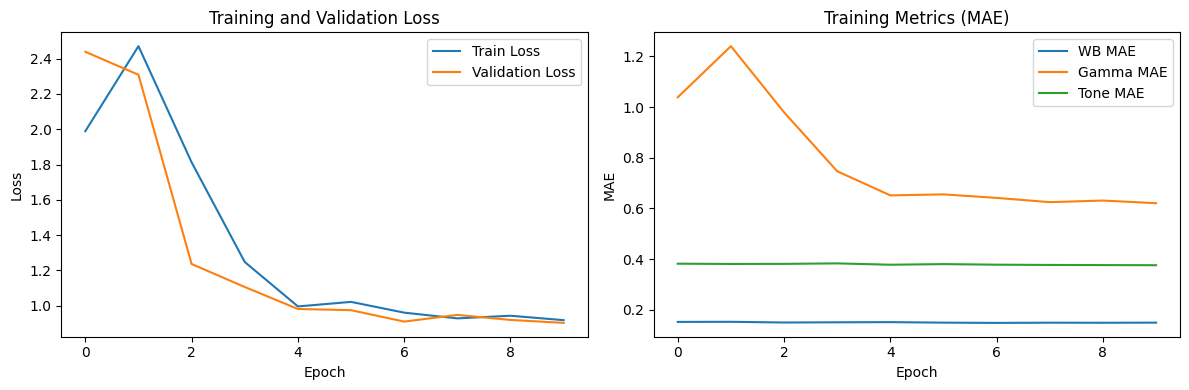

In [ ]:

# Test the model with a sample image


# Function to visualize training history
def plot_training_history(history):
    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy (MAE)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['wb_output_mae'], label='WB MAE')
    plt.plot(history.history['gamma_output_mae'], label='Gamma MAE')
    plt.plot(history.history['tone_output_mae'], label='Tone MAE')
    plt.title('Training Metrics (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize training history if available
if history:
    plot_training_history(history)



## all the 40,000 train images

## Training EfficientnetB0 100 epochs

In [ ]:

# Set environment variables for faster training
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Reduce TensorFlow logging
os.environ["TF_NUM_INTEROP_THREADS"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "8"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=2"  # Enable XLA JIT compilation

# Configure TensorFlow for performance
configure_performance()

# Display TensorFlow version and available devices
print(f"TensorFlow version: {tf.__version__}")
print(f"Devices available: {tf.config.list_physical_devices()}")

# Argument parsing
parser = argparse.ArgumentParser(description='Train filter parameter prediction model')
parser.add_argument('--input_shape', type=int, nargs=3, default=[200, 200, 3], help='Input shape (height, width, channels)')
parser.add_argument('--batch_size', type=int, default=64, help='Initial batch size')
parser.add_argument('--epochs', type=int, default=100, help='Number of training epochs')
parser.add_argument('--image_dir', type=str, default="/content/drive/MyDrive/Info_assurance/synthetic_data/train_sample", help='Directory containing synthetic images')
parser.add_argument('--model_dir', type=str, default="/content/drive/MyDrive/Info_assurance/models/CNN-PP2_models", help='Directory to save models')
parser.add_argument('--use_local_storage', action='store_true', help='Copy data to local storage for faster access')
parser.add_argument('--use_smaller_model', action='store_true', help='Use MobileNetV2 instead of EfficientNetB0 for faster training')
args, unknown = parser.parse_known_args()

Configuring TensorFlow for maximum performance...
TensorFlow version: 2.18.0
GPU memory growth enabled for 1 GPUs
XLA compilation enabled
TensorFlow version: 2.18.0
Devices available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:



# Training parameters
INPUT_SHAPE = tuple(args.input_shape)
INITIAL_BATCH_SIZE = args.batch_size
EPOCHS = args.epochs

# Paths
SYNTHETIC_IMAGES_DIR = args.image_dir
MODEL_SAVE_PATH = os.path.join(args.model_dir, "train100_efficientnet_filter_predictor.keras")
FINE_TUNED_MODEL_PATH = os.path.join(args.model_dir, "train100_efficientnet_filter_predictor_finetuned.keras")

# Copy data to local storage if requested
if args.use_local_storage:
    SYNTHETIC_IMAGES_DIR = copy_to_local_storage(SYNTHETIC_IMAGES_DIR)

# Make sure the model directory exists
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

# Find CSV file
PARAMS_CSV_PATH = os.path.join(SYNTHETIC_IMAGES_DIR, "train_synthetic_params_matched.csv")
# PARAMS_CSV_PATH = '/content/drive/MyDrive/Info_assurance/synthetic_data/c_train_synthetic_params.csv'
if not os.path.exists(PARAMS_CSV_PATH):
    print(f"Warning: CSV file not found at {PARAMS_CSV_PATH}")
    print("Checking directory contents:")
    if os.path.exists(SYNTHETIC_IMAGES_DIR):
        print(f"Contents of {SYNTHETIC_IMAGES_DIR}:")
        for file in os.listdir(SYNTHETIC_IMAGES_DIR):
            if file.endswith('.csv'):
                print(f"  Found CSV: {file}")

        # Look for CSV files with similar names
        csv_files = [f for f in os.listdir(SYNTHETIC_IMAGES_DIR) if f.endswith('.csv')]
        if csv_files:
            print(f"Using first available CSV file: {csv_files[0]}")
            PARAMS_CSV_PATH = os.path.join(SYNTHETIC_IMAGES_DIR, csv_files[0])
    else:
        print(f"Directory {SYNTHETIC_IMAGES_DIR} does not exist")

# Initialize the predictor with chosen settings
predictor = FilterParameterPredictor(
    input_shape=INPUT_SHAPE,
    batch_size=INITIAL_BATCH_SIZE,
    use_smaller_model=args.use_smaller_model
)

# Build the model
model = predictor.build_model()
model.summary()

# Optimize model for speed
model = optimize_model_for_speed(model, INPUT_SHAPE)

# Find optimal batch size
optimal_batch_size = find_optimal_batch_size(model, INPUT_SHAPE, start_batch_size=INITIAL_BATCH_SIZE)
print(f"Using optimized batch size: {optimal_batch_size}")
predictor.batch_size = optimal_batch_size

# Try loading CSV file directly to check its structure
try:
    start_time = time.time()
    df = pd.read_csv(PARAMS_CSV_PATH)
    print(f"CSV loaded successfully in {time.time() - start_time:.2f} seconds")
    print(f"CSV has {len(df)} rows and these columns: {df.columns.tolist()}")

    # Check for any missing columns that might cause errors
    required_columns = ['filename', 'wb_r', 'wb_g', 'wb_b', 'gamma', 'contrast', 'usm', 'fog_param'] + [f'tone_{i}' for i in range(8)]
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"WARNING: Missing required columns: {missing_columns}")
except Exception as e:
    print(f"Error loading CSV: {e}")

# Train the model with optimized parameters
print("Starting initial training phase...")
history = predictor.train(SYNTHETIC_IMAGES_DIR, PARAMS_CSV_PATH, MODEL_SAVE_PATH, EPOCHS)


# Clean up memory
predictor.clear_image_cache()
gc.collect()

print("Process completed.")


Configuring TensorFlow for maximum performance...
TensorFlow version: 2.18.0
GPU memory growth enabled for 1 GPUs
XLA compilation enabled
Mixed precision enabled. Compute dtype: float16, Variable dtype: float32
Using EfficientNetB0 backbone...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 7, 7, 1280)     │      4,049,571 │ input_layer_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1280)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        655,872 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 3)              │          1,539 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            513 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 8)              │          4,104 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │            513 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            513 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │            513 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ wb_output (Lambda)        │ (None, 3)              │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gamma_output (Lambda)     │ (None, 1)              │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tone_output (Lambda)      │ (None, 8)              │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contrast_output (Lambda)  │ (None, 1)              │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ usm_output (Lambda)       │ (None, 1)              │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fog_output (Lambda)       │ (None, 1)              │              0 │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,713,138 (17.98 MB)

 Trainable params: 663,567 (2.53 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Optimizing model architecture for speed...
Could not determine model FLOPs: module 'tensorflow' has no attribute 'python'
Finding optimal batch size...
Batch size 64 works fine
Batch size 128 works fine
Batch size 256 works fine
Batch size 512 works fine
Using optimized batch size: 1024
CSV loaded successfully in 0.07 seconds
CSV has 20151 rows and these columns: ['wb_r', 'wb_g', 'wb_b', 'gamma', 'tone_0', 'tone_1', 'tone_2', 'tone_3', 'tone_4', 'tone_5', 'tone_6', 'tone_7', 'contrast', 'usm', 'fog_param', 'uniform_fog', 'filename']
Starting initial training phase...
Preparing data generators...
CSV loaded with 20151 records
Found 20151 existing images out of 20151
Preloading all 20151 images into memory. This may take a while...
Available memory: 9.84 GB
Estimated memory required: 9.01 GB
Consider reducing input resolution or using a subset of images
Loading images 1-100 of 20151...
Processed 100/20151 images (143.07 images/sec)
Loading images 101-200 of 20151...
Processed 200/20151 i

In [ ]:

import shutil

In [ ]:

# # hist_results_dir = "/content/drive/MyDrive/Info_assurance/results/history.json"
# # os.makedirs(hist_results_dir, exist_ok=True)
# # # Save the training history (initial training phase) to a JSON file
# # with open(hist_results_dir, 'w') as f:
# #     json.dump(history.history, f)


# # print("Training history has been saved to 'history.json'")

# # Define the results directory and ensure it exists
# results_dir = "/content/drive/MyDrive/Info_assurance/results"
# os.makedirs(results_dir, exist_ok=True)

# # Build the file path for the history JSON file
# hist_results_file = os.path.join(results_dir, "history.json")

# # Save the training history (initial training phase) to the JSON file
# with open(hist_results_file, 'w') as f:
#     json.dump(history.history, f)

# print(f"Training history has been saved to '{hist_results_file}'")

# Define the results directory and ensure it exists
results_dir = "/content/drive/MyDrive/Info_assurance/results"
os.makedirs(results_dir, exist_ok=True)

# Build the file path for the history JSON file
hist_results_file = os.path.join(results_dir, "history.json")

# If hist_results_file exists and is a directory, remove it
if os.path.isdir(hist_results_file):
    print(f"'{hist_results_file}' is a directory. Removing it to save the file.")
    shutil.rmtree(hist_results_file)

# Save the training history (initial training phase) to the JSON file
with open(hist_results_file, 'w') as f:
    json.dump(history.history, f)

print(f"Training history has been saved to '{hist_results_file}'")

'/content/drive/MyDrive/Info_assurance/results/history.json' is a directory. Removing it to save the file.
Training history has been saved to '/content/drive/MyDrive/Info_assurance/results/history.json'


In [ ]:
# # Optionally fine-tune the model if initial training was successful
# if history:
#     print("Starting fine-tuning phase...")
#     fine_tune_history = predictor.fine_tune(
#         SYNTHETIC_IMAGES_DIR,
#         PARAMS_CSV_PATH,
#         FINE_TUNED_MODEL_PATH,
#         fine_tune_epochs=5
#     )
# else:
#     print("Initial training failed. Skipping fine-tuning.")

# # Clean up memory
# predictor.clear_image_cache()
# gc.collect()

# print("Process completed.")

In [ ]:
ft_results_dir = "/content/drive/MyDrive/Info_assurance/results/fine_tune_history.json"
os.makedirs(ft_results_dir, exist_ok=True)
# Save the fine-tuning history to a separate JSON file
with open(ft_results_dir, 'w') as f:
    json.dump(fine_tune_history.history, f)

print("Fine-tuning history has been saved to 'fine_tune_history.json'.")

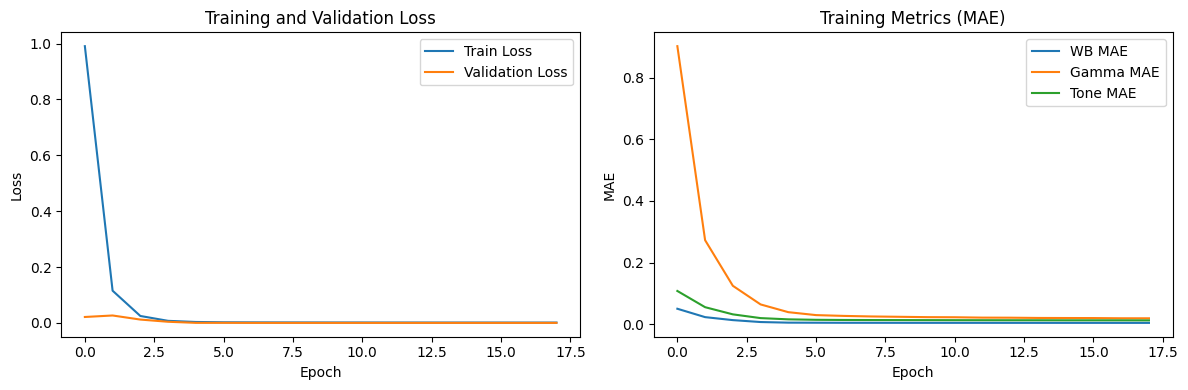

In [ ]:

# Test the model with a sample image


# Function to visualize training history
def plot_training_history(history):
    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy (MAE)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['wb_output_mae'], label='WB MAE')
    plt.plot(history.history['gamma_output_mae'], label='Gamma MAE')
    plt.plot(history.history['tone_output_mae'], label='Tone MAE')
    plt.title('Training Metrics (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize training history if available
if history:
    plot_training_history(history)



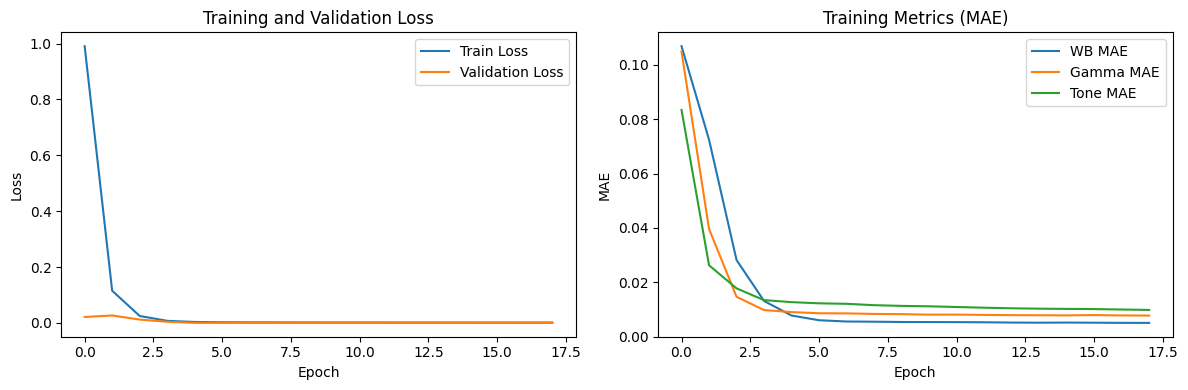

In [ ]:

# Function to visualize training history
def plot_training_history(history):
    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy (MAE)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['fog_output_mae'], label='WB MAE')
    plt.plot(history.history['contrast_output_mae'], label='Gamma MAE')
    plt.plot(history.history['usm_output_mae'], label='Tone MAE')
    plt.title('Training Metrics (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize training history if available
if history:
    plot_training_history(history)

In [ ]:

# Example prediction (after training)
test_image = os.path.join(SYNTHETIC_IMAGES_DIR, "synthetic_example.jpg")  # Replace with an actual image path
if os.path.exists(test_image):
    predictions = predictor.predict_parameters(test_image)
    print("Predicted parameters:", predictions)

## Test

In [ ]:
# Define paths for your test set
TEST_IMAGES_DIR = "test_images"
TEST_PARAMS_CSV_PATH = os.path.join(TEST_IMAGES_DIR, "test_params.csv")

# Read the test CSV file
test_df = pd.read_csv(TEST_PARAMS_CSV_PATH)

# Create a list of image paths from the CSV filenames
test_filenames = test_df['filename'].values
test_image_paths = [os.path.join(TEST_IMAGES_DIR, filename) for filename in test_filenames]

# Extract parameter arrays (make sure these column names match your CSV)
test_wb_params = test_df[['wb_r', 'wb_g', 'wb_b']].values
test_gamma_params = test_df[['gamma']].values
test_tone_params = test_df[[f'tone_{i}' for i in range(8)]].values
test_contrast_params = test_df[['contrast']].values
test_usm_params = test_df[['usm']].values
test_fog_params = test_df[['fog_param']].values  # Only one fog parameter

# Create the test generator (no augmentation)
test_gen = predictor.custom_data_generator(
    test_image_paths,
    test_wb_params,
    test_gamma_params,
    test_tone_params,
    test_contrast_params,
    test_usm_params,
    test_fog_params,
    batch_size=BATCH_SIZE,
    augment=False
)


In [ ]:
num_test_samples = len(test_image_paths)
test_steps = num_test_samples // BATCH_SIZE


In [ ]:
test_metrics = predictor.model.evaluate(test_gen, steps=test_steps, verbose=1)
print("Test Metrics:", test_metrics)
